In [1]:
import pandas as pd
import numpy as np
import itertools
import re, os
import string
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.externals import joblib

In [3]:
def sentence_to_words(raw_sentence, drug_g=None):
    """This function modifies the sentences to words by removing html marks,
    non-letters, drug names etc."""
    sent_text = BeautifulSoup(raw_sentence, "html.parser").get_text()  # Remove HTML markings
    letters = re.sub('[^a-zA-Z]', ' ', sent_text)  # Remove non-letters
    sent = letters.lower()
    if drug_g == drug_g:  # Check for nan values
        drug = re.sub('[^a-zA-Z1-9]', ' ', drug_g)
        sent = re.sub(str(drug.lower()), '', sent)  # Remove Drug Names
        words = sent.split()
    else:
        words = sent.split()
    stop_words = stopwords.words('english')
    important_words = [w for w in words if not w in stop_words]
    return ' '.join(important_words)

In [4]:
def stemming(text):
    stemmer = SnowballStemmer('english')
    return [stemmer.stem(w) for w in text]

In [5]:
def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

In [6]:
class df_column_extractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        
    def transform(self, df, y=None):
        return df[[self.column]]
            
    def fit(self, df, y=None):
        return self

In [7]:
class Converter(BaseEstimator, TransformerMixin):
    def transform(self, df, y=None):
        return df.values.ravel()
            
    def fit(self, df, y=None):
        return self

In [10]:
sentence_to_words('A 31 year old man had fever and he took crocin. After that he started having rash.', 'crocin')

u'year old man fever took started rash'

#### Reading Data

In [11]:
data = pd.read_excel(r'C:\Users\binit.kumar.bhagat\Documents\PV First\Drug Classification\Model Training\Data For Model Training 10_Jul.xlsx', sheetname='Final')
data.columns = ['Case ID','Drug Role','Trade Name','Generic Name','Text']
data.shape

(1005, 5)

In [12]:
data.head()

,Case ID,Drug Role,Trade Name,Generic Name,Text
0,full text- 763,Suspect,NaN,Ibuprofen,"He presented in November 1991, 3 hours after i..."
1,full text- 919,Suspect,NaN,Tenofovir,This patient appears to have developed proxima...
2,full text- 919,Suspect,NaN,Tenofovir,This constellation of blood and urinary derang...
3,full text- 919,Suspect,NaN,Tenofovir,Renal biopsy revealed toxic acute tubular necr...
4,full text- 919,Suspect,NaN,Tenofovir,Fanconi syndrome is the result of either an in...


#### Text Cleaning

In [13]:
clean_text = []
for i in range(len(data)):
    #print data['Generic Name'][i],i
    clean_text.append(sentence_to_words(data['Text'][i], data['Generic Name'][i]))

In [12]:
clean_text

[u'presented november hours inges tion mg tablets',
 u'patient appears developed proximal tubular dysfunction first evidenced presence orthoglycemic glycosuria glycosuria normal blood glucose developed approximately years initiated therapy nucleotide reverse transcriptase inhibitor',
 u'constellation blood urinary derange ments coupled proximal tubular epithelial cells urinary sediment consistent proximal tubular injury fanconi syndrome likely secondary',
 u'renal biopsy revealed toxic acute tubular necrosis predomi nantly involving proximal tubules consistent toxicity',
 u'fanconi syndrome result either inborn error metabolism result tubular toxicity drug induced renal fanconi syndrome uncommon reported several antiretroviral medications including',
 u'although prospective clinical trials demonstrated low incidence renal toxicity',
 u'first related renal toxicity case described fanconi syndrome acute renal failure nephrogenic diabetes insipidus temporally associated use drug improved 

#### Stemming and Lemmitization

In [13]:
stemmed_text = stemming(clean_text)
lemmatized_text = lemmatization(clean_text)

In [14]:
data['Clean_Text'], data['Stemmed'], data['Lemmatized'] = clean_text, stemmed_text, lemmatized_text

In [15]:
#data

In [9]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

#### Frequency

In [16]:
data['Frequency'] = np.ones(len(data), dtype=int)
for i in range(len(data)):
    data['Frequency'][i] = int(len(data[(data['Case ID']==data['Case ID'][i]) & (data['Generic Name']==data['Generic Name'][i])]))

C:\Users\binit\AppData\Local\conda\conda\envs\python27\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [487]:
#data[:100]

#### Data Distribution

In [17]:
data['Drug Role'].value_counts()

Suspect        753
Concomitant    130
Treatment      122
Name: Drug Role, dtype: int64

#### Target Modification

In [18]:
data['Drug Role'] = data['Drug Role'].replace('Suspect','Not Concomitant').replace('Treatment','Not Concomitant')

In [19]:
data['Drug Role'].value_counts()

Not Concomitant    875
Concomitant        130
Name: Drug Role, dtype: int64

#### Set X and y

In [20]:
X = data.drop('Drug Role', axis=1)
y = data['Drug Role']

### Stratified K-Fold Cross Validation

In [25]:
skf = StratifiedKFold(n_splits=5, random_state=111)
for train_index, val_index in skf.split(X,y): 
    print("Train:", train_index, "Validation:", val_index) 
    print 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
    X_train, X_test = X.iloc[train_index], X.iloc[val_index] 
    y_train, y_test = y[train_index], y[val_index]

('Train:', array([ 191,  192,  193,  194,  195,  196,  198,  199,  200,  201,  202,
        203,  204,  205,  206,  207,  208,  209,  210,  211,  212,  213,
        214,  215,  216,  217,  218,  219,  220,  221,  222,  223,  224,
        225,  226,  227,  228,  229,  230,  231,  232,  233,  234,  235,
        236,  237,  238,  239,  240,  241,  242,  243,  244,  245,  246,
        247,  249,  250,  251,  252,  253,  254,  255,  256,  257,  258,
        259,  260,  261,  262,  263,  264,  265,  266,  267,  272,  273,
        274,  275,  276,  277,  278,  279,  280,  281,  282,  283,  284,
        287,  288,  289,  290,  291,  292,  293,  294,  295,  296,  297,
        298,  299,  300,  301,  302,  304,  305,  306,  307,  308,  309,
        310,  311,  313,  314,  315,  316,  317,  318,  319,  320,  321,
        322,  323,  324,  325,  326,  327,  328,  329,  330,  331,  332,
        333,  334,  335,  336,  337,  338,  339,  340,  341,  342,  343,
        344,  345,  346,  347,  348,  34

### Classifiers

In [26]:
forest = RandomForestClassifier(n_estimators=50, random_state=300)
svm = SVC(C=0.4, gamma=0.1, kernel='linear', random_state=200, probability=True)

In [27]:
#X_train['Stemmed']

### Pipeline and Featureunion

In [28]:
vec_svd_pipe = Pipeline([('stem', df_column_extractor('Stemmed')),
                         ('convert', Converter()),
                         ('vec', TfidfVectorizer(analyzer="word", ngram_range=(1,2), max_df=0.8, max_features=3000)),
                         ('svd', TruncatedSVD(n_components=300, n_iter=10, random_state=222))
                        ])

In [29]:
word_features = vec_svd_pipe.fit_transform(X_train)

In [30]:
word_features.shape

(804L, 300L)

In [31]:
model = forest
pipeline = Pipeline([('union', FeatureUnion([                     
                         ('vec_svd', vec_svd_pipe),
                         ('freq', df_column_extractor('Frequency'))
                                            ])),
                     ('model', model)
                    ])

In [32]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('vec_svd', Pipeline(memory=None,
     steps=[('stem', df_column_extractor(column='Stemmed')), ('convert', Converter()), ('vec', TfidfVectorizer(analyzer='word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>,...timators=50, n_jobs=1,
            oob_score=False, random_state=300, verbose=0, warm_start=False))])

In [33]:
pred = pipeline.predict(X_test)

In [34]:
print 'Accuracy = ',accuracy_score(y_test, pred)
print '\n',classification_report(y_test, pred)
print '\n', confusion_matrix(y_test, pred)

Accuracy =  0.870646766169

                 precision    recall  f1-score   support

    Concomitant       0.00      0.00      0.00        26
Not Concomitant       0.87      1.00      0.93       175

    avg / total       0.76      0.87      0.81       201


[[  0  26]
 [  0 175]]


C:\Users\binit\AppData\Local\conda\conda\envs\python27\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### K-Fold Accuracy Test

In [35]:
X = data.drop('Drug Role', axis=1)
y = data['Drug Role']
skf = StratifiedKFold(n_splits=5, random_state=111)
index = 0
for train_index, val_index in skf.split(X,y): 
    if index>3:
        break
    else:
        #print("Train:", train_index, "Validation:", val_index) 
        #print 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
        X_train, X_test = X.iloc[train_index], X.iloc[val_index] 
        y_train, y_test = y[train_index], y[val_index]

        pipeline.fit(X_train, y_train)
        pred = pipeline.predict(X_test)
        print '\n\n{}-Fold Accuracy = '.format(index+1),accuracy_score(y_test, pred)
        print '\n',classification_report(y_test, pred)
        print '\n', confusion_matrix(y_test, pred)
        index += 1



1-Fold Accuracy =  0.875621890547

                 precision    recall  f1-score   support

    Concomitant       1.00      0.04      0.07        26
Not Concomitant       0.88      1.00      0.93       175

    avg / total       0.89      0.88      0.82       201


[[  1  25]
 [  0 175]]


2-Fold Accuracy =  0.89552238806

                 precision    recall  f1-score   support

    Concomitant       1.00      0.19      0.32        26
Not Concomitant       0.89      1.00      0.94       175

    avg / total       0.91      0.90      0.86       201


[[  5  21]
 [  0 175]]


3-Fold Accuracy =  0.910447761194

                 precision    recall  f1-score   support

    Concomitant       1.00      0.31      0.47        26
Not Concomitant       0.91      1.00      0.95       175

    avg / total       0.92      0.91      0.89       201


[[  8  18]
 [  0 175]]


4-Fold Accuracy =  0.980099502488

                 precision    recall  f1-score   support

    Concomitant       1.00    

#### Selecting hyperparameters

#### SVM

Accuracy= 0.870646766169 	C= 0.1 	Gamma= 0.1 	Kernel= linear
Accuracy= 0.870646766169 	C= 0.1 	Gamma= 0.01 	Kernel= linear
Accuracy= 0.940298507463 	C= 0.2 	Gamma= 0.1 	Kernel= linear
Accuracy= 0.940298507463 	C= 0.2 	Gamma= 0.01 	Kernel= linear
Accuracy= 0.955223880597 	C= 0.3 	Gamma= 0.1 	Kernel= linear
Accuracy= 0.955223880597 	C= 0.3 	Gamma= 0.01 	Kernel= linear
Accuracy= 0.960199004975 	C= 0.4 	Gamma= 0.1 	Kernel= linear
Accuracy= 0.960199004975 	C= 0.4 	Gamma= 0.01 	Kernel= linear
Accuracy= 0.955223880597 	C= 0.5 	Gamma= 0.1 	Kernel= linear
Accuracy= 0.955223880597 	C= 0.5 	Gamma= 0.01 	Kernel= linear
Accuracy= 0.945273631841 	C= 0.6 	Gamma= 0.1 	Kernel= linear
Accuracy= 0.945273631841 	C= 0.6 	Gamma= 0.01 	Kernel= linear
Accuracy= 0.945273631841 	C= 0.7 	Gamma= 0.1 	Kernel= linear
Accuracy= 0.945273631841 	C= 0.7 	Gamma= 0.01 	Kernel= linear
Accuracy= 0.930348258706 	C= 0.8 	Gamma= 0.1 	Kernel= linear
Accuracy= 0.930348258706 	C= 0.8 	Gamma= 0.01 	Kernel= linear
Accuracy= 0.8955

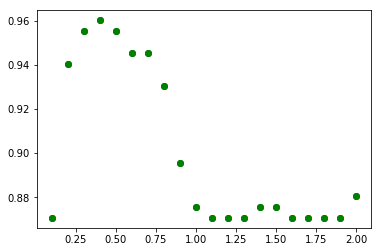

In [523]:
C_list = np.arange(0.1, 2.1, 0.1)
#C_list = [i for i in range(1,5) if i%1 == 0]
g_list = [1e-1, 1e-2]
k_list = ['linear']
acc_list = []

for k in k_list:
    for c in C_list:
        for g in g_list:        
            
            svm = SVC(C=c, gamma=g, kernel=k, random_state=200, probability=False)
            model = svm
            pipeline = Pipeline([('union', FeatureUnion([                     
                                     ('vec_svd', vec_svd_pipe),
                                     ('freq', df_column_extractor('Frequency'))
                                                        ])),
                                 ('model', model)
                                ])
            pipeline.fit(X_train, y_train)
            pred = pipeline.predict(X_test)
            acc = accuracy_score(y_test, pred)
            print 'Accuracy=',acc,'\tC=', c,'\tGamma=', g,'\tKernel=', k
            acc_list.append(acc)
n = len(g_list)   
new_list = [y for x in C_list for y in n*[x]]
plt.plot(new_list, acc_list, 'go')
plt.show()

In [ ]:

Accuracy= 0.955223880597 	C= 0.4 	Gamma= 0.1 	Kernel= linear
Accuracy= 0.955223880597 	C= 20 	Gamma= 0.01  Kernel= rbf

Accuracy= 0.960199004975 	C= 23 	Gamma= 0.01 	Kernel= rbf
Accuracy= 0.960199004975 	n_comp= 420

Accuracy= 0.960199004975 	C= 0.4 	Gamma= 0.1 	Kernel= linear



#### Random Forest

In [526]:
x_list = [n for n in range(20,200) if n%10==0]
accu_list = []
for x in x_list:        
            
    forest = RandomForestClassifier(n_estimators=x, random_state=300)
    model = forest
    pipeline = Pipeline([('union', FeatureUnion([                     
                             ('vec_svd', vec_svd_pipe),
                             ('freq', df_column_extractor('Frequency'))
                                                ])),
                         ('model', model)
                        ])
    pipeline.fit(X_train, y_train)
    pred1 = pipeline.predict(X_test)
    accu = accuracy_score(y_test, pred1)
    print 'Accuracy=',acc,'\tNo. of trees=', x
    accu_list.append(accu)
    

Accuracy= 0.880597014925 	No. of trees= 20
Accuracy= 0.880597014925 	No. of trees= 30
Accuracy= 0.880597014925 	No. of trees= 40
Accuracy= 0.880597014925 	No. of trees= 50
Accuracy= 0.880597014925 	No. of trees= 60
Accuracy= 0.880597014925 	No. of trees= 70
Accuracy= 0.880597014925 	No. of trees= 80
Accuracy= 0.880597014925 	No. of trees= 90
Accuracy= 0.880597014925 	No. of trees= 100
Accuracy= 0.880597014925 	No. of trees= 110
Accuracy= 0.880597014925 	No. of trees= 120
Accuracy= 0.880597014925 	No. of trees= 130
Accuracy= 0.880597014925 	No. of trees= 140
Accuracy= 0.880597014925 	No. of trees= 150
Accuracy= 0.880597014925 	No. of trees= 160
Accuracy= 0.880597014925 	No. of trees= 170
Accuracy= 0.880597014925 	No. of trees= 180
Accuracy= 0.880597014925 	No. of trees= 190


### Selecting number of components

Accuracy= 0.965174129353 	n_comp= 290
Accuracy= 0.980099502488 	n_comp= 291
Accuracy= 0.980099502488 	n_comp= 292
Accuracy= 0.980099502488 	n_comp= 293
Accuracy= 0.980099502488 	n_comp= 294
Accuracy= 0.980099502488 	n_comp= 295
Accuracy= 0.975124378109 	n_comp= 296
Accuracy= 0.975124378109 	n_comp= 297
Accuracy= 0.960199004975 	n_comp= 298
Accuracy= 0.975124378109 	n_comp= 299
Accuracy= 0.980099502488 	n_comp= 300
Accuracy= 0.975124378109 	n_comp= 301
Accuracy= 0.975124378109 	n_comp= 302
Accuracy= 0.980099502488 	n_comp= 303
Accuracy= 0.980099502488 	n_comp= 304
Accuracy= 0.975124378109 	n_comp= 305
Accuracy= 0.975124378109 	n_comp= 306
Accuracy= 0.975124378109 	n_comp= 307
Accuracy= 0.975124378109 	n_comp= 308
Accuracy= 0.975124378109 	n_comp= 309
Accuracy= 0.980099502488 	n_comp= 310
Accuracy= 0.970149253731 	n_comp= 311
Accuracy= 0.980099502488 	n_comp= 312
Accuracy= 0.970149253731 	n_comp= 313
Accuracy= 0.970149253731 	n_comp= 314
Accuracy= 0.970149253731 	n_comp= 315
Accuracy= 0.

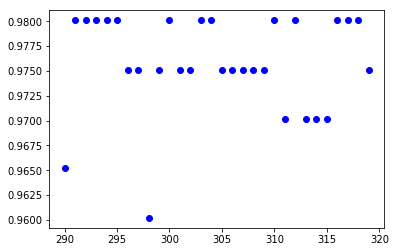

In [529]:
comp_list = [i for i in np.arange(290,320) if i%1 == 0]

forest = RandomForestClassifier(n_estimators=50, random_state=300)
svm = SVC(C=0.4, gamma=0.1, kernel='rbf', random_state=200, probability=True)

for model in [forest]:
    accu_list = []
    for comp in comp_list:   
        
        vec_svd_pipe = Pipeline([('stem', df_column_extractor('Stemmed')),
                             ('convert', Converter()),
                             ('vec', TfidfVectorizer(analyzer="word", ngram_range=(1,2), max_df=0.8, max_features=3000)),
                             ('svd', TruncatedSVD(n_components=comp, n_iter=10, random_state=222))
                            ])

        pipeline = Pipeline([('union', FeatureUnion([                     
                                 ('vec_svd', vec_svd_pipe),
                                 ('freq', df_column_extractor('Frequency'))
                                                    ])),
                             ('model', model)
                            ])
        pipeline.fit(X_train, y_train)
        pred = pipeline.predict(X_test)
        accu = accuracy_score(y_test, pred)
        print 'Accuracy=',accu,'\tn_comp=', comp
        accu_list.append(accu)
    plt.plot(comp_list, accu_list, 'bo')
    plt.show()

### Saving the Model

In [459]:
path = r'C:\Users\binit\Documents\PV First\Drug Classification\PKL files'

In [42]:
joblib.dump(pipeline, r'C:\Users\binit\Documents\PV First\Drug Classification\PKL files\forest_98_13_Jul.pkl')

['C:\\Users\\binit\\Documents\\PV First\\Drug Classification\\PKL files\\forest_98_13_Jul.pkl']

#### Loading Model

In [43]:
clf = joblib.load(r'C:\Users\binit\Documents\PV First\Drug Classification\PKL files\forest_98_13_Jul.pkl')

In [44]:
new_pred = clf.predict(X_test)

In [45]:
print 'Accuracy = ',accuracy_score(y_test, new_pred)
print '\n',classification_report(y_test, new_pred)
print '\nconfusion_matrix\n',confusion_matrix(y_test, new_pred)

Accuracy =  0.980099502488

                 precision    recall  f1-score   support

    Concomitant       1.00      0.85      0.92        26
Not Concomitant       0.98      1.00      0.99       175

    avg / total       0.98      0.98      0.98       201


confusion_matrix
[[ 22   4]
 [  0 175]]
